# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250419-15-11-14 - 15-11-14


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\five_d.txt.
It is known that the shortest distance is 19


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    if sdl.mode == 8:
        #input is all zeros
        unrepeated_input = torch.full((1,sdl.qubits), 0).float().to(device)
    elif sdl.mode == 9:
        #input is 0.5
        unrepeated_input = torch.full((1,sdl.qubits), 0.5).float().to(device)

    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

In [9]:
unrepeated_input.size()

torch.Size([1, 5])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 5])


Set up model with gradient required:

In [11]:
model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn,
                sdl.hot_start,
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

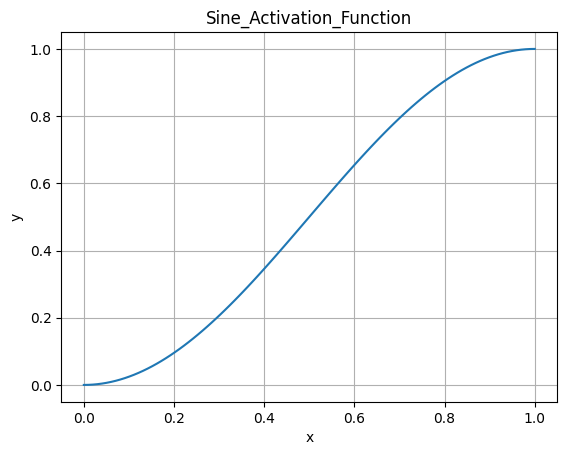

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[-0.4337, -0.4373,  0.3829,  0.1133, -0.1354],
        [-0.0842, -0.3440, -0.2814,  0.0786,  0.4190],
        [-0.4019, -0.1003, -0.3143, -0.1337, -0.3677],
        [-0.2969, -0.1629, -0.2524, -0.0578, -0.2374],
        [ 0.1429, -0.2133,  0.3497,  0.2705,  0.1921]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.1255,  0.0691,  0.4173,  0.0204,  0.0109], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 0.1442,  0.3647, -0.2118,  0.1042,  0.3573],
        [-0.2822,  0.3628, -0.1095, -0.3570,  0.4453],
        [ 0.0806, -0.3860, -0.1316,  0.2544,  0.4454],
        [ 0.3651,  0.1290, -0.0643, -0.0144,  0.0771],
        [ 0.2760, -0.2237,  0.2870, -0.3394,  0.0342]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([-0.2619, -0.1407, -0.0196,  0.3376,  0.0172], device='cuda:0',
       requires_grad=True)}


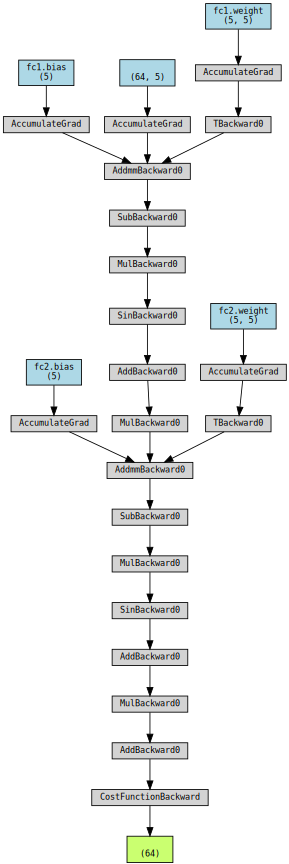

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 26.250 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 122.82
Epoch 0, fc2.weight grad: 82.45
Epoch 0, fc2.bias grad: 220.62
The time taken to run the code is 10.070 seconds
Saving data to results\results.csv
An error occurred while saving the data to results\results.csv: [Errno 13] Permission denied: 'results\\results.csv'
Detailed data for Run ID: 20250419-15-11-14 - 15-11-14 successfully added to results\20250419-15-11-14\15-11-14.csv


In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 19.000 at epoch 0.
The best known cost is 19.000


Plot loss ratio by epoch:

Graph for Run ID: 20250419-15-11-14-15-11-14 being saved to graphs\20250419-15-11-14\15-11-14.png


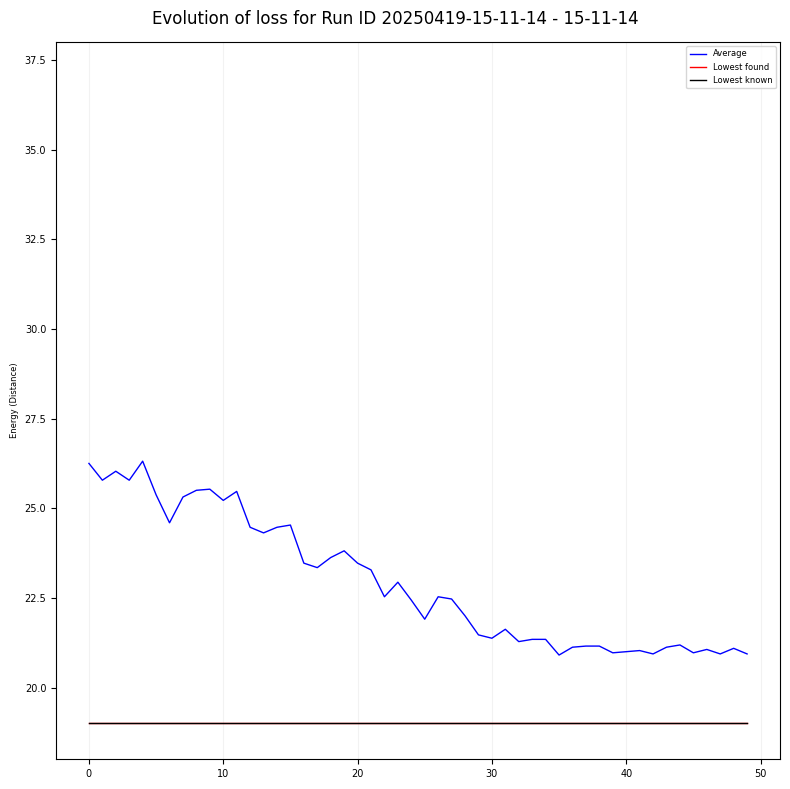

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[-0.4337, -0.4373,  0.3829,  0.1133, -0.1354],
        [-0.0842, -0.3440, -0.2814,  0.0786,  0.4190],
        [-0.4019, -0.1003, -0.3143, -0.1337, -0.3677],
        [-0.2969, -0.1629, -0.2524, -0.0578, -0.2374],
        [ 0.1429, -0.2133,  0.3497,  0.2705,  0.1921]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.0703,  0.1772,  0.6839,  0.0044,  0.0033], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 0.1456,  0.3671, -0.1369,  0.1042,  0.3573],
        [-0.2780,  0.3637, -0.0005, -0.3570,  0.4453],
        [ 0.0614, -0.3947, -0.4920,  0.2542,  0.4453],
        [ 0.3577,  0.1261, -0.1786, -0.0146,  0.0771],
        [ 0.2835, -0.2293,  0.3048, -0.3392,  0.0343]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.1962, -0.0194, -0.5951,  0.1256,  0.1488], device='cuda:0',
       requires_grad=True)
